In [1]:
import os
os.chdir('C:\\Users\\Administrator\\Downloads\\ML Lab')

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from timeseires.utils.to_split import to_split
from timeseires.utils.multivariate_multi_step import multivariate_multi_step
from timeseires.utils.multivariate_single_step import multivariate_single_step
from timeseires.utils.univariate_multi_step import univariate_multi_step
from timeseires.utils.univariate_single_step import univariate_single_step
from timeseires.utils.CosineAnnealingLRS import CosineAnnealingLRS
from timeseires.callbacks.EpochCheckpoint import EpochCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint
from timeseires.callbacks.TrainingMonitor import TrainingMonitor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, Bidirectional, Add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D,TimeDistributed
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,MaxPooling1D,Concatenate,AveragePooling1D, GlobalMaxPooling1D, Input
from tensorflow.keras.models import Sequential,Model
import pandas as pd
import time, pickle
import numpy as np
import tensorflow.keras.backend as K
import tensorflow
from tensorflow.keras.layers import Input, Reshape, Lambda
from tensorflow.keras.layers import Layer, Flatten, LeakyReLU, concatenate, Dense
from tensorflow.keras.regularizers import l2
import glob
import h5py
import matplotlib.pyplot as plt
from keras.callbacks import Callback

In [31]:
#lookback = 24
model = None
start_epoch = 0
time_steps=24
num_features=21

In [6]:
def MLP():
    model = Sequential()
    model.add(Flatten(input_shape=(time_steps , num_features)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    return model

In [7]:
model1 = MLP()
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 504)               0         
                                                                 
 dense (Dense)               (None, 32)                16160     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 16,193
Trainable params: 16,193
Non-trainable params: 0
_________________________________________________________________


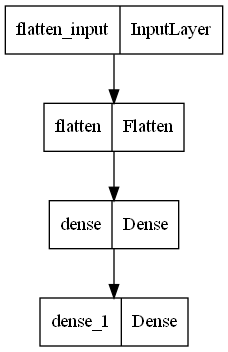

In [8]:
tensorflow.keras.utils.plot_model(model1 )

In [9]:
checkpoints = r'C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab7\\E1-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
OUTPUT_PATH = r'C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab7'
FIG_PATH = os.path.sep.join([OUTPUT_PATH,"\history.png"])
JSON_PATH = os.path.sep.join([OUTPUT_PATH,"\history.json"])

In [10]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]

In [11]:
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model =MLP()
    opt = Adam(1e-3)
    model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-4)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] compiling model...


In [12]:
import os
path_dataset ='C:\\Users\\Administrator\\Downloads\\ML Lab\\AEP_hourly\\processed'
path_tr = os.path.join(path_dataset, 'AEP_train.csv')
df_tr = pd.read_csv(path_tr)
train_set = df_tr.iloc[:].values
path_v = os.path.join(path_dataset, 'AEP_validation.csv')
df_v = pd.read_csv(path_v)
validation_set = df_v.iloc[:].values 
path_te = os.path.join(path_dataset, 'AEP_test.csv')
df_te = pd.read_csv(path_te)
test_set = df_te.iloc[:].values 

path_scaler = os.path.join(path_dataset, 'AEP_Scaler.pkl')
scaler         = pickle.load(open(path_scaler, 'rb'))

train_set.shape, validation_set.shape, test_set.shape

C:\Users\Administrator\anaconda3\envs\Time1\lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


((84907, 21), (24259, 21), (12130, 21))

In [15]:
df_te.head(1)

,aep,Is_holiday1,Is_holiday2,Is_Weekend1,Is_Weekend2,sin_month,cos_month,sin_week,cos_week,sin_hour,...,sin_wintert,cos_wintert,sin_springt,cos_springt,sin_summert,cos_summert,sin_fallt,cos_fallt,sin_year_dayt,cos_year_dayt
0,0.518532,1.0,0.0,1.0,0.0,1.0,6.123234e-17,0.866025,-0.5,-0.707107,...,0.0,1.0,1.0,6.123234e-17,0.0,1.0,0.0,1.0,0.956235,0.2926


In [17]:
test_set[0]

array([ 5.18532385e-01,  1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        0.00000000e+00,  1.00000000e+00,  6.12323400e-17,  8.66025404e-01,
       -5.00000000e-01, -7.07106781e-01, -7.07106781e-01,  0.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  6.12323400e-17,  0.00000000e+00,
        1.00000000e+00,  0.00000000e+00,  1.00000000e+00,  9.56234827e-01,
        2.92600336e-01])

In [30]:
time_steps=2
num_features=21

In [44]:
train_X , train_y = univariate_multi_step(train_set, time_steps, target_col=0,target_len=)

In [45]:
train_X[0]

array([[ 1.69100212e-01,  1.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00, -8.66025404e-01,
         5.00000000e-01, -8.66025404e-01, -5.00000000e-01,
         2.58819045e-01,  9.65925826e-01,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         6.12323400e-17, -9.99768502e-01,  2.15160974e-02],
       [ 1.41395233e-01,  1.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00, -8.66025404e-01,
         5.00000000e-01, -8.66025404e-01, -5.00000000e-01,
         5.00000000e-01,  8.66025404e-01,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         6.12323400e-17, -9.99768502e-01,  2.15160974e-02]])

In [46]:
train_y[0]

array([0.12623237, 0.12030451])

In [27]:
time_steps =2
train_X , train_y = univariate_multi_step(train_set, time_steps, target_col=1,target_len=2)

In [33]:
train_X[0]

array([[ 1.69100212e-01,  1.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00, -8.66025404e-01,
         5.00000000e-01, -8.66025404e-01, -5.00000000e-01,
         2.58819045e-01,  9.65925826e-01,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         6.12000000e-17, -9.99768502e-01,  2.15160970e-02],
       [ 1.41395233e-01,  1.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00, -8.66025404e-01,
         5.00000000e-01, -8.66025404e-01, -5.00000000e-01,
         5.00000000e-01,  8.66025404e-01,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         6.12000000e-17, -9.99768502e-01,  2.15160970e-02],
       [ 1.26232372e-01,  1.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00, -8.66025404e-01,
         5.00000000e-01, -8.66025404e-01, -5.00000000e

In [34]:
train_y[0]

array([0.16167478])

In [32]:
start = time.time()
train_X , train_y = univariate_multi_step(train_set, time_steps, target_col=0,target_len=1)
validation_X, validation_y = univariate_multi_step(validation_set, time_steps, target_col=0,target_len=1)
test_X, test_y = univariate_multi_step(test_set, time_steps, target_col=0,target_len=1)
print('Time Consumed', time.time()-start, "sec")

Time Consumed 0.9597721099853516 sec


In [13]:
epochs = 60
verbose = 1 #0
batch_size = 32
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,
                    verbose = verbose)

Epoch 1/60
2651/2653 [============================>.] - ETA: 0s - loss: 0.0425 - mae: 0.0425 - mape: 1830.0505
Epoch 1: val_loss improved from inf to 0.02679, saving model to C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab7\E1-cp-0001-loss0.03.h5
2653/2653 [==============================] - 7s 2ms/step - loss: 0.0425 - mae: 0.0425 - mape: 1828.9777 - val_loss: 0.0268 - val_mae: 0.0268 - val_mape: 11.0248
Epoch 2/60
2652/2653 [============================>.] - ETA: 0s - loss: 0.0246 - mae: 0.0246 - mape: 765.9785
Epoch 2: val_loss improved from 0.02679 to 0.02149, saving model to C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab7\E1-cp-0002-loss0.02.h5
2653/2653 [==============================] - 6s 2ms/step - loss: 0.0246 - mae: 0.0246 - mape: 765.8170 - val_loss: 0.0215 - val_mae: 0.0215 - val_mape: 9.6927
Epoch 3/60
2651/2653 [============================>.] - ETA: 0s - loss: 0.0213 - mae: 0.0213 - mape: 376.4086
Epoch 3: val_loss improved from 0.02149 to 0.

In [15]:

model = load_model(r'C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab7\E1-cp-0038-loss0.01.h5')

y_pred_scaled   = model.predict(test_X)
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled)) 
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

379/379 [==============================] - 1s 1ms/step
Mean Absolute Error (MAE): 164.07
Median Absolute Error (MedAE): 133.39
Mean Squared Error (MSE): 44254.42
Root Mean Squared Error (RMSE): 210.37
Mean Absolute Percentage Error (MAPE): 1.12 %
Median Absolute Percentage Error (MDAPE): 0.93 %


y_test_unscaled.shape=  (12105, 1)
y_pred.shape=  (12105, 1)


# Fine Tuning

In [16]:
checkpoints = r'C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab7\E2-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
model=r'C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab7\E1-cp-0038-loss0.01.h5'
start_epoch= 39

In [17]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model = PC.build(time_steps=24, num_features=21, reg=0.0005)
    opt = Adam(1e-3)
    model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-4)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] loading C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab7\E1-cp-0038-loss0.01.h5...
[INFO] old learning rate: 0.0010000000474974513
[INFO] new learning rate: 9.999999747378752e-05


In [18]:
epochs = 10
verbose = 1 #0
batch_size = 32
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,
                        verbose = verbose)

Epoch 1/10
2625/2653 [============================>.] - ETA: 0s - loss: 0.0091 - mae: 0.0091 - mape: 94.3988
Epoch 1: val_loss improved from inf to 0.00950, saving model to C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab2\E2-cp-0001-loss0.01.h5
2653/2653 [==============================] - 7s 2ms/step - loss: 0.0091 - mae: 0.0091 - mape: 93.4461 - val_loss: 0.0095 - val_mae: 0.0095 - val_mape: 4.6159
Epoch 2/10
2653/2653 [==============================] - ETA: 0s - loss: 0.0090 - mae: 0.0090 - mape: 45.7124
Epoch 2: val_loss improved from 0.00950 to 0.00920, saving model to C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab2\E2-cp-0002-loss0.01.h5
2653/2653 [==============================] - 6s 2ms/step - loss: 0.0090 - mae: 0.0090 - mape: 45.7124 - val_loss: 0.0092 - val_mae: 0.0092 - val_mape: 4.3533
Epoch 3/10
2632/2653 [============================>.] - ETA: 0s - loss: 0.0090 - mae: 0.0090 - mape: 53.8044
Epoch 3: val_loss did not improve from 0.00920
2653/2

In [19]:

model = load_model(r'C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab7\E2-cp-0006-loss0.01.h5')

y_pred_scaled   = model.predict(test_X)
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled)) 
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

379/379 [==============================] - 1s 1ms/step
Mean Absolute Error (MAE): 144.75
Median Absolute Error (MedAE): 113.65
Mean Squared Error (MSE): 36189.68
Root Mean Squared Error (RMSE): 190.24
Mean Absolute Percentage Error (MAPE): 0.98 %
Median Absolute Percentage Error (MDAPE): 0.79 %


y_test_unscaled.shape=  (12105, 1)
y_pred.shape=  (12105, 1)
